<a href="https://colab.research.google.com/github/nedokormysh/Stepik_Competitive_DS/blob/week_6/solution_12_2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Условие

**Задача: Обучи модели для блендинга и стекинга, выбери лучшие**

Датасеты: quickstart_train.csv и quickstart_test.csv.

Регрессионный таргет: столбец target_reg , метрика RMSE.

Для блендинга и стекинга выбрать 3 модели:

* Любые 2 бустинга на ваш выбор.
* Любую другую модель (не бустинг).

Для стекинга в качестве метамодели желательно взять простой алгоритм (регрессию, KNN и т. п.).

Далее реализуем блендинг и стекинг и делаем финальное предсказание:

* можно выбрать предсказание от блендинга;
* можно от стекинга;
* можно ансамбль блендинга и стекинга;
* можно блендинг блендинга и стекинга с весами 🙈.

**Дополнительные условия:**

Особенно ничем вас не ограничиваем, можно пользоваться всем арсеналом: подбирать гиперпараметры в Optuna, генерить\отбирать признаки и т. п. Но желательно сосредоточиться на освоении блендинга со стекингом и подбором моделей для них.
Сохраняем в submission.csv только колонки car_id и target_reg.
В конце добавляем выводы о проделанных экспериментах, что зашло\не зашло.
Желательно, чтобы на выполнение всего ноутбука уходило не более 30 мин.

**Критерии оценки (максимум 10 баллов за задание):**

*Оформление (3 балла)*

прослеживается логика в последовательности решения задачи; в неочевидных местах добавлены поясняющие комментарии и маркдаун ячейки; ноутбук не перегружен лишней информацией, огромными простынями аутпутов ячеек (настраиваем verbose, скрываем служебную информацию после установки библиотек);
хороший codestyle: код соответствует PEP 8 и DRY, названия переменных и функций понятны либо соответствуют общепринятым нормам (train, test, model, pd, xgb и т. п.);
в конце присутствуют выводы о проделанных экспериментах.

*Решение задачи и выполнение доп. условий (3 балла)*

ноутбук выполняется до конца без ошибок (присутствуют все аутпуты в пдф);
реализованы блендинг со стекингом и выполнены доп. условия;
проведена работа над воспроизводимостью (зафиксированы все random seeds).

*Использование возможностей фреймворка (2 балла)*

корректная подготовка данных для использования в ансамбле;
используется early_stopping, многопоточность (n_threads) и пр.;
правильная подготовка категориальных признаков для каждой модели;
корректное использование пайплайнов и функций sklearn или другой библиотеки.

*Дополнительные баллы (макс. 2 балла)*

* 1 балл, если проводился подбор гиперпараметров;
* 1 балл, если использованы минимум 2 вида графики, и на основе их сделаны какие-либо выводы (не просто график ради красивой картинки, а с пользой для дела);
* 1 балл, если для ансамблей использовались библиотеки, не затронутые или кратко упомянутые в уроках (pystacknet и пр.);
* 1 балл, если использовались ансамблевые методы, не затронутые в уроках (стекинг с фичами, стекинг с весами и пр.).

In [ ]:
!pip install catboost -q
!pip install pytorch-tabnet -q
!pip install optuna -q
!pip install gerrychain -q
# !pip install lightgbm -q
# !pip install xgboost -q

# Загрузка библиотек

In [ ]:
from typing import Any
import re

from gerrychain.random import random

import pandas as pd
import numpy as np
import seaborn as sns
import time

import optuna
from optuna.integration import CatBoostPruningCallback, LightGBMPruningCallback, XGBoostPruningCallback
from optuna.integration.pytorch_lightning import PyTorchLightningPruningCallback
optuna.logging.set_verbosity(optuna.logging.WARNING)

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
import lightgbm as lgb
from lightgbm import LGBMRegressor, early_stopping, Dataset
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, StackingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import NuSVR

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import copy

import pickle
import warnings
warnings.simplefilter('ignore')

In [ ]:
# фиксируем random state согласно инструкции для optuna
!export PYTHONHASHSEED=0
random.seed(7575)

# Загрузка данных

In [ ]:
start = time.time()

In [ ]:
PATH_TRAIN = 'https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_train.csv'
PATH_TEST = 'https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_test.csv'

## Оптимизируем объём памяти.

In [ ]:
def reduce_mem_usage(df: pd.DataFrame) -> pd.DataFrame:
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

def import_data(file: str)-> pd.DataFrame:
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [ ]:
print('train')
train = import_data(PATH_TRAIN)

print('-' * 80)
print('test')
test = import_data(PATH_TEST)

train
Memory usage of dataframe is 0.30 MB
Memory usage after optimization is: 0.16 MB
Decreased by 47.7%
--------------------------------------------------------------------------------
test
Memory usage of dataframe is 0.23 MB
Memory usage after optimization is: 0.14 MB
Decreased by 40.9%


## Подготовка данных

array([[<Axes: title={'center': 'car_rating'}>,
        <Axes: title={'center': 'year_to_start'}>,
        <Axes: title={'center': 'riders'}>,
        <Axes: title={'center': 'year_to_work'}>,
        <Axes: title={'center': 'target_reg'}>],
       [<Axes: title={'center': 'mean_rating'}>,
        <Axes: title={'center': 'distance_sum'}>,
        <Axes: title={'center': 'rating_min'}>,
        <Axes: title={'center': 'speed_max'}>,
        <Axes: title={'center': 'user_ride_quality_median'}>],
       [<Axes: title={'center': 'deviation_normal_count'}>,
        <Axes: title={'center': 'user_uniq'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

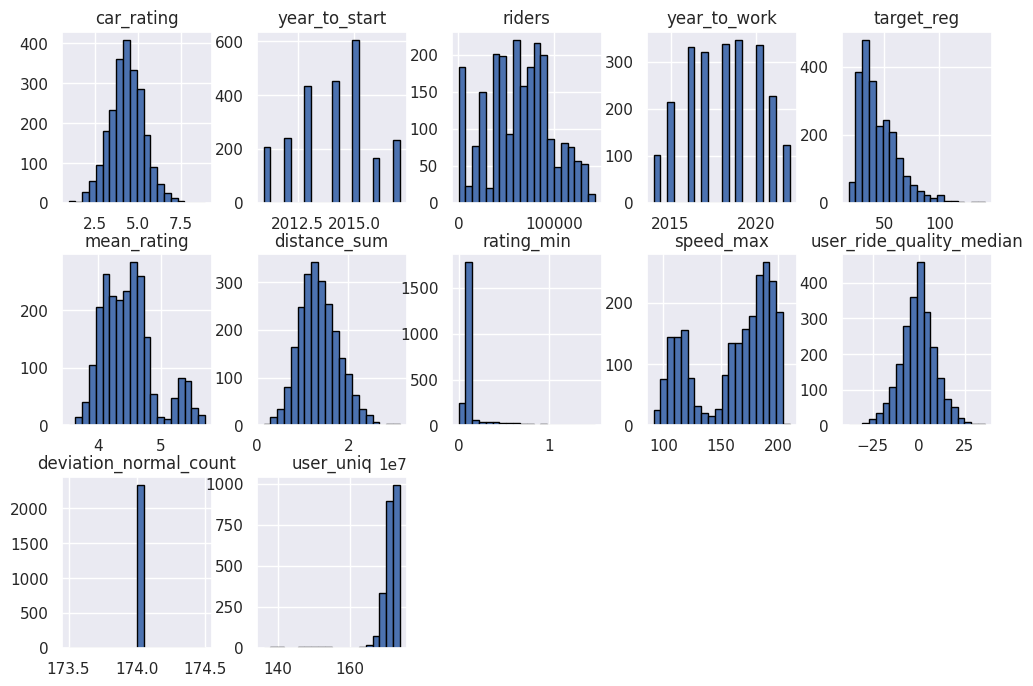

In [ ]:
train.hist(figsize=(12,8), layout=(-1,5), bins=20, edgecolor='black')

На гистограммах видно, что признак deviation_normal_count - константный, поэтому не будем его использовать для обучения. Также видно, что числовые признаки придётся стандартизировать для обучения, особенно не бустинговых моделей. Также потребуется стандартизировать и целевую переменную.

In [ ]:
# инициализируем листы числовых, категориальных, целевых признаков и признаки, которые не потребуются для анализа.
cat_features = ['model', 'car_type', 'fuel_type']
cat_features_indxs = [0, 1, 2]
targets = [#'target_class',
           'target_reg']
features2drop = ['car_id', 'deviation_normal_count', 'target_class']

filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]

print(f'\033[1mcat_features:\033[0m {cat_features}, \033[1mamount\033[0m = {len(cat_features)}')
print(f'\033[1mnum_features:\033[0m {num_features}, \033[1mamount\033[0m = {len(num_features)}')
print(f'\033[1mtargets:\033[0m {targets}, \033[1mamount\033[0m = {len(targets)}')

cat_features: ['model', 'car_type', 'fuel_type'], amount = 3
num_features: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'user_uniq'], amount = 10
targets: ['target_reg'], amount = 1


In [ ]:
# Заменим тип данных object на category в категориальных признаках

for col in cat_features:
    train[col] = train[col].astype("category")

for col in cat_features:
    test[col] = test[col].astype("category")

In [ ]:
# инициализируем номер случайного состояния, словарь лучших моделей, словарь для результатов
# датасет для формирования результатов
R_S = 7575
N_EST = 400
N_TRIALS = 100
sampler = optuna.samplers.TPESampler(seed=R_S)

bst_mdls = {}
mean_scores = {}

df_sub = pd.DataFrame(test['car_id'])

In [ ]:
# получаем разбиение на фичи и целевую переменную
X = train[filtered_features].drop(targets, axis=1, errors="ignore")
y = train["target_reg"]

# разбиение на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=R_S)

# подготовка тестовых данных
X_sub = test[filtered_features].drop(targets, axis=1, errors="ignore")

## Вспомогательные функции и классы

### Класс для нормализации цифровых признаков

Т.к. catboost может работать с категориальными признаками самостоятельно, то будем подавать dataframe в нашу модель. При этом стандартизируем числовые признаки. (пусть для модели catboost, насколько я понимаю, это и не принципиальное действие). Для этого напишем кастомный класс transformer.

In [ ]:
class CustomTransformer(TransformerMixin):
    '''
    .. notes::
    Класс трансформации признаков.
    Числовые данные нормализуются или стандартизируются.
    Категориальные признаки не изменяются.
    После трансформаци возвращается датафрейм.
    '''
    def __init__(self,
                 scaler_type: Any=None,
                 cat_feats: list[str]=None,
                 with_mean: bool=True,
                 with_std: bool=True,
                 feature_range: tuple[int, int]=(0, 1)):

        self.scaler_type = scaler_type
        if scaler_type:
            self.scaler = StandardScaler(with_mean=with_mean, with_std=with_std)
        else:
            self.scaler = MinMaxScaler(feature_range=feature_range)

        self.cat_feats = cat_feats

        # print('Init done')
    def fit(self, X: pd.DataFrame, y: pd.Series=None):
        return self

    def transform(self, X: pd.DataFrame, y: pd.Series=None) -> pd.DataFrame:
        X_ = X.copy()
        X_cat = X_[self.cat_feats]
        num_feats = [i for i in X_.columns if i not in self.cat_feats]
        X_num = X_[num_feats]
        X_num = pd.DataFrame(self.scaler.fit_transform(X_num), columns=num_feats)

        res = pd.concat([X_cat.reset_index(), X_num], axis=1)
        return res.set_index('index')

### Функция для шага обучения

будем использовать scheduler в моделях LGBM и XGB

In [ ]:
# функция для шага обучения
def lr_gen_simple(init_lr: float=0.1, epoch: int=400) -> list[float]:
    '''
    :param init_lr: initial number for learning rate
    :type init_lr: float, defaults to 0.1
    :param epoch: amount of epochs
    :type epoch: int, defaults to 400

    :rtype: list[float]

    .. notes:: Функция для формирования листа со значениями шага обучения
    на каждой эпохе.
    -----
    Параметры:
    init_lr - инициализирующий шаг обучения
    epoch - количество эпох

    '''
    decay = init_lr / epoch
    lr_list = [init_lr/(1 + decay * i) for i in range(1, epoch + 1)]

    return lr_list

### Класс для применения моделей.

Соберём класс, в котором будут лежать 2 функции: preparing_features и fit.

preparing_features будет готовить пайплайн для обработки признаков и применения модели. (часть для обработки признаков будет возвраться отдельно). Для catboost и tabnet будем использовать кастомные классы обработки признаков, которые ввели выше. Для остальных моделей: числовые признаки - стандартизируем, категориальные преобразуем при помощи one hot encoding.

fit собственно будет применять нашу модель. Возвращать обученную модель и предсказания.

In [ ]:
class FitClass():
    '''
    Класс для применения моделей.
    preparing_features - фунция для создания пайплайнов обработки
    fit - примененение модели
    '''
    @staticmethod
    def preparing_features(name: str, algorithm: Any) -> tuple[Any, Any]:
        '''
        :param name: name of regressor algorithm
        :type name: str
        :param algorithm: class of regressor algorithm
        :type algorithm: Any

        :rtype: tuple[Any, Any]
        :returns: preprocessor pipe for columns and pipe model

        .. notes::
        -----
        Принимает на вход название алгоритма и алгоритм.
        Возвращает цепочку для преобразования фичей,
        цепочку для преобразования фичей и применения модели.
        '''

        if name == 'CatBoostRegressor':
              preprocessor = CustomTransformer(True, cat_feats=cat_features)

              pipe = Pipeline([('feature_preprocessor', preprocessor),
                              ('model', algorithm)])
        # elif name == 'TabNetRegressor':
        #     preprocessor = CustomTransformerNN(True, cat_feats=cat_features)

        #     pipe = Pipeline([('feature_preprocessor', preprocessor),
        #                       ('model', algorithm)])
        else:
            numeric_transformer = Pipeline(
                steps=[("imputer", SimpleImputer(strategy="median")),
                      ("scaler", StandardScaler())])
            categorical_transformer = Pipeline(
                steps=[("encoder", OneHotEncoder(handle_unknown="ignore")),
                      #  ("selector", SelectPercentile(chi2, percentile=50)),
                      ])
            preprocessor = ColumnTransformer(
                transformers=[("num", numeric_transformer, num_features),
                              ("cat", categorical_transformer, cat_features)])

            pipe = Pipeline([('feature_preprocessor', preprocessor),
                            ('model', algorithm)])

        return preprocessor, pipe

    @staticmethod
    def fit(name: str,
            pipe: Any,
            preprocessor: Any,
            X_train: pd.DataFrame,
            X_val: pd.DataFrame,
            y_train: pd.Series,
            y_val: pd.Series,
            fit_params: dict,
            callbacks=[]):
        '''
        :param name: name of regressor algorithm
        :type name: str
        :param pipe: pipe of preprocessor for features and model
        :type pipe: Any
        :param preprocessor: pipe of preprocessor for features
        :type preprocessor: Any
        :param X_train: train features
        :type X_train: pandas.DataFrame
        :param X_val: validation features
        :type X_val: pandas.DataFrame
        :param y_train: train targer
        :type y_train: pandas.Series
        :param y_val: validation target
        :type y_val: pandas.Series

        :rtype: tuple[np.array, Any]
        :returns: array of predictions, model
        .. notes::
        -----
        Принимает название алгоритма. Применяет алгоритм с заданными параметрами
        к данным.
        Возвращает предсказание. И обученную модель.
        '''
        if name == 'TabNetRegressor':
            target_sc = StandardScaler()
            y_train = target_sc.fit_transform(y_train.values.reshape(-1, 1))
            X_val_eval_NN = X_val.copy()
            eval_set_pipe = Pipeline(steps = [('feature_preprocessor', preprocessor)])
            X_val_eval_NN = eval_set_pipe.fit(X_train).transform(X_val_eval_NN)
            y_val_eval_NN = target_sc.transform(y_val.values.reshape(-1, 1))
        else:
            X_val_eval = X_val.copy()
            eval_set_pipe = Pipeline(steps = [('feature_preprocessor', preprocessor)])
            X_val_eval = eval_set_pipe.fit(X_train).transform(X_val_eval)

        wrapped_model = TransformedTargetRegressor(regressor=pipe, transformer=StandardScaler())

        if name in ['KNeighborsRegressor', 'ElasticNet', 'RandomForestRegressor', 'GaussianProcessRegressor', 'NuSVR', 'MLPRegressor', 'GradientBoostingRegressor']:
            wrapped_model.fit(X_train,
                              y_train,
                              **fit_params)
            y_pred = wrapped_model.predict(X_val)
        elif name == 'TabNetRegressor':
            pipe.fit(X_train, y_train,
                    model__eval_set=[(X_val_eval_NN, y_val_eval_NN)],
                    **fit_params)
            y_pred = pipe.predict(X_val)
            y_pred = target_sc.inverse_transform(np.array(y_pred).reshape(-1, 1))
            wrapped_model = pipe

        else:
            if callbacks:
                wrapped_model.fit(X_train,
                                  y_train,
                                  **fit_params,
                                  model__callbacks=callbacks,
                                  model__eval_set=[(X_val_eval, y_val)])
                # запускаем процесс прунинга для catboost
                if name == 'CatBoostRegressor':
                    callbacks[-1].check_pruned()
            else:
                wrapped_model.fit(X_train,
                                  y_train,
                                  model__eval_set=[(X_val_eval, y_val)],
                                  **fit_params)

            y_pred = wrapped_model.predict(X_val)

        if name == 'TabNetRegressor':
            return y_pred, wrapped_model, target_sc

        return y_pred, wrapped_model

### Fit algorithm optuna

Объявим функцию обучения для всех моделей. Будем использовать механизм подбора гиперпараметров optuna.

In [ ]:
# функция применения алгоритма, когда применяем optuna
def fit_algorithm_optuna(trial: optuna.trial,
                         train: pd.DataFrame,
                         val: pd.DataFrame,
                         algorithm: Any,
                         init_params: dict,
                         grid: dict,
                         fit_params: dict,
                         r_s=R_S,
                         callbacks = []):
    '''
    :param trial: standart optuna parameter
    :type trial: optuna.trial
    :param train: train dataframe
    :type train: pandas.DataFrame
    :param val: validation dataframe
    :type val: pd.DataFrame
    :param algorithm: class of regressor algorithm
    :type algorithm: Any
    :param init_params: initial parameters
    :type init_params: dict
    :param grid: grid of parameters
    :type grid: dict
    :param fit_params: parameters to fit
    :type fit_params: dict
    :param r_s: random state
    :type r_s: int, defaults to 7575
    :param callbacks: callbacks
    :type callbacks: list, defaults to []

    :rtype: tuple[Any, np.array]
    :returns: model, array of predictions
    .. notes::
    -----
    Принимает объект trial из optuna, данные для обучения и валидации, алгоритм, параметры.
    Алгоритм обучается и применяется.
    Возвращает обученную модель и предсказанное значение для валидационной выборки.
    '''

    X_train, y_train = train
    X_val, y_val = val

    # получаем на вход сетку с параметрами для перебора. для пары алгоритмов будем
    # добавлять параметры в сетку, в зависимости от некоторых условий.
    if algorithm.__name__ == 'CatBoostRegressor':
        if grid["bootstrap_type"] == "Bayesian":
            grid["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 20)
        elif grid["bootstrap_type"] == "Bernoulli":
            grid["subsample"] = trial.suggest_float("subsample", 0.1, 1, step=0.01)
    elif algorithm.__name__ == 'XGBRegressor':
        if grid["booster"] == "gbtree" or grid["booster"] == "dart":
            grid["max_depth"] = trial.suggest_int("max_depth", 1, 9)
            grid["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
            grid["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
            grid["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
            grid["tree_method"]: trial.suggest_categorical("tree_method", ['hist', 'approx'],)
        if grid["booster"] == "dart":
            grid["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
            grid["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
            grid["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
            grid["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    elif algorithm.__name__ == 'LGBMRegressor':
        if init_params['boosting_type'] != 'goss':
            grid['bagging_fraction'] = trial.suggest_float('bagging_fraction', 0.5, 1.0, step=0.01)
            grid['bagging_freq'] = trial.suggest_int('bagging_freq', 1, 10)
        if init_params['boosting_type'] == 'dart':
            grid['drop_rate'] = trial.suggest_float('drop_rate', 0.1, 0.5, step=0.01)

    rgr = algorithm(**init_params, **grid)

    # применяем метод preparing_features - он на вернёт способ обработки данных и общий пайплайн модели
    preprocessor, pipe = FitClass.preparing_features(algorithm.__name__, rgr)
    # для алгоритма TabNet будем возвращать ещё и обученный объект scaler для целевой переменной
    if algorithm.__name__ == 'TabNetRegressor':
        y_pred, wrapped_model, target_sc = FitClass.fit(algorithm.__name__, pipe, preprocessor, X_train, X_val, y_train, y_val, fit_params, callbacks)
        return wrapped_model, y_pred, target_sc

    y_pred, wrapped_model = FitClass.fit(algorithm.__name__, pipe, preprocessor, X_train, X_val, y_train, y_val, fit_params, callbacks)
    # возвращаем модель и прогноз
    return wrapped_model, y_pred

# Модели

## Catboost

In [ ]:
# функция для рассчёта метрики в механизме перебора optuna
def objective_catboost(trial: optuna.trial, return_models:bool=False):

    '''
    :param trial: standart optuna parameter
    :type trial: optuna.trial
    :param return_models: parameter to return fitted model or not
    :type return_models: bool, defaults to False

    :rtype: float | tuple[float, Any]
    :returns: mean value of RMSE on folds, model
    .. notes::
    -----
    Принимает объект trial из optuna и булево значение для возможности возврата модели.

    Разбиваем данные на фолды, и подаём в функцию fit algorithm_optuna на каждом разбиении.

    '''
    # будем использовать pruning
    pruning_callback = CatBoostPruningCallback(trial, "RMSE")
    callbacks = [pruning_callback]

    # параметры, которые не будем перебирать
    init_params = {'loss_function': 'RMSE',
                   'random_seed': R_S,
                   'thread_count': -1,
                   'verbose': 0,
                   'task_type': "CPU",
                   'iterations' : N_EST, # Можно не перебирать, есть Early-Stopping,
                   'cat_features': cat_features}
    # сетка с параметрами для перебора
    grid = {'learning_rate': trial.suggest_float("learning_rate", 0.019, 0.026 , step=0.001),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 300, 400),
            'l2_leaf_reg': trial.suggest_int("l2_leaf_reg", 2, 10),
            'max_bin': trial.suggest_int('max_bin', 200, 300),
            'boosting_type': trial.suggest_categorical("boosting_type", ["Ordered",
                                                                        #  "Plain"
                                                                         ]),
            'bootstrap_type': trial.suggest_categorical("bootstrap_type", [#"Bayesian",
                                                                           #"Bernoulli",
                                                                           "MVS"]),
            'depth': trial.suggest_int("depth", 8, 11),
            'colsample_bylevel': trial.suggest_float("colsample_bylevel", 0.61, 0.64, step=0.01),
            # 'subsample': trial.suggest_float("colsample_bylevel", 0.01, 0.95),
            'used_ram_limit': "14gb"}

    # параметры для применения модели. используем early stopping
    fit_params = {'model__cat_features': cat_features,
                  'model__verbose': 0,
                  'model__early_stopping_rounds': 200,
                  'model__plot': False}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)
    # разбиваем на фолды
    scores, models = [], []

    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        # Разбиваем на обучающую и валидационную выборки. Подаём данные, параметры и тип алгоритма функцию
        # fit_algorithm_optuna, которая вернёт нам модель и прогноз для валидационных данных

        model, y_pred = fit_algorithm_optuna(trial,
                                             train_data,
                                             valid_data,
                                             CatBoostRegressor,
                                             init_params,
                                             grid,
                                             fit_params,
                                             callbacks=callbacks)
        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        models.append(model)
        # break
    # записываем лучшие модели и результат по фолдам
    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [ ]:
%%time
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                            #  pruner=optuna.pruners.HyperbandPruner(),
                            direction="minimize", study_name="Catboost_Regressor", sampler=sampler)
study.optimize(objective_catboost,
               n_trials=N_TRIALS,
               n_jobs=-1,
               show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 10min 19s, sys: 6.48 s, total: 10min 25s
Wall time: 6min 13s


In [ ]:
# optuna.visualization.plot_optimization_history(study)

In [ ]:
# params = ['learning_rate',
#           'min_data_in_leaf',
#           'l2_leaf_reg',
#           'max_bin',
#           'boosting_type',
#           'bootstrap_type',
#           'depth',
#           'colsample_bylevel']

# optuna.visualization.plot_slice(study, params=params, target_name='rmse')

In [ ]:
# optuna.visualization.plot_param_importances(study)

Для уменьшения времени работы всего ноутбука все параметры были несколько раз подобраны с помощью optuna и ограничены диапазоны параметров.

In [ ]:
mean_scores['Catboost_score'], bst_mdls['Catboost_model'] = objective_catboost(optuna.trial.FixedTrial(study.best_params), return_models=True)

In [ ]:
# Сделаем прогноз для тестовых данных
preds = bst_mdls['Catboost_model'].predict(X_sub)
# Добавляем наши предсказания для тестовой выборки в таблицу результатов
df_sub['Catboost_target'] = preds
df_sub.head()

,car_id,Catboost_target
0,P17494612l,44.269476
1,N-1530212S,32.148753
2,B-1154399t,32.534999
3,F12725233R,34.120984
4,l-1139189J,32.356600


## LGBM

In [ ]:
def objective_lgbm(trial, return_models=False):

    pruning_callback = LightGBMPruningCallback(trial, "rmse")

    callbacks = [
                 lgb.early_stopping(stopping_rounds=50, verbose=0),
                 lgb.reset_parameter(learning_rate=lr_gen_simple(trial.suggest_float("lr_init", 0.0001, 0.5, step=0.001), N_EST)),
                #  pruning_callback
                ]

    init_params = {'metric': "RMSE",
                   'objective': 'regression',
                   'boosting_type': trial.suggest_categorical("boosting_type",
                                                              [ "gbdt",
                                                                "dart"]),
                   'random_seed': R_S,
                   'n_jobs': -1,
                   'verbose': -1,
                   'force_row_wise': True,
                   'num_iterations' : N_EST, # Можно не перебирать, есть Early-Stopping
                  #  'cat_features': cat_features
                   }

    grid = {'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
            'reg_alpha': trial.suggest_int("reg_alpha", 1e-3, 1),
            'reg_lambda': trial.suggest_int("reg_lambda", 1e-3, 1),
            # 'max_bin': trial.suggest_int('max_bin', 100, 300),
            'num_leaves': trial.suggest_int('num_leaves', 4, 7),
            'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 0.95, step=0.01),
            'subsample': trial.suggest_float("subsample", 0.5, 1, step=0.01)}

    fit_params = { }

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []

    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                      train_data,
                                      valid_data,
                                      LGBMRegressor,
                                      init_params,
                                      grid,
                                      fit_params,
                                      callbacks=callbacks)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        models.append(model)
        # break

    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

Learning rate настраиваем через sheduler. LGBM работает очень быстро, поэтому убрал pruning. Кроме того, при обучении лучшей модели на фиксированных параметрах и подаче pruning в callbacks обучение упадёт.

In [ ]:
%%time
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                            direction="minimize", study_name="LGBM_Regressor", sampler=sampler)
study.optimize(objective_lgbm,
               n_trials=N_TRIALS,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 1min 32s, sys: 19.8 s, total: 1min 52s
Wall time: 1min 15s


In [ ]:
# params = ['min_child_samples',
#           'reg_alpha',
#           'reg_lambda',
#           'num_leaves',
#           'colsample_bytree',
#           'subsample',]

# optuna.visualization.plot_slice(study, params=params, target_name='rmse')

In [ ]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['LGBM_score'], bst_mdls['LGBM_model'] = objective_lgbm(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 11.612262446913308, params {'lr_init': 0.0271, 'boosting_type': 'gbdt', 'min_child_samples': 14, 'reg_alpha': 1, 'reg_lambda': 1, 'num_leaves': 5, 'colsample_bytree': 0.7, 'subsample': 0.94, 'bagging_fraction': 0.81, 'bagging_freq': 6}
[LightGBM] [Info] Start training from score -0.000030
[LightGBM] [Info] Start training from score -0.000002
[LightGBM] [Info] Start training from score -0.000034


In [ ]:
preds = bst_mdls['LGBM_model'].predict(X_sub)
df_sub['LGBM_target'] = preds

## Elastic net

In [ ]:
def objective_elastik(trial, return_models=False):
    init_params = {'random_state': R_S,}

    grid = {'max_iter': trial.suggest_int("max_iter", 600, 800, step=4),
            'l1_ratio': trial.suggest_float("l1_ratio", 0.001, 0.3, step=0.01),
            'alpha':  trial.suggest_float("alpha", 0.001, 0.3, step=0.01)}

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []

    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        model, y_pred = fit_algorithm_optuna(trial,
                                             train_data,
                                             valid_data,
                                             ElasticNet,
                                             init_params,
                                             grid,
                                             fit_params)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        models.append(model)
        # break

    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [ ]:
%%time
study = optuna.create_study(direction="minimize", study_name="Elastic_Regressor", sampler=sampler)
study.optimize(objective_elastik,
               n_trials=N_TRIALS,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 23.2 s, sys: 15.8 s, total: 39 s
Wall time: 22.9 s


In [ ]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['Elastic_score'], bst_mdls['Elastic_model'] = objective_elastik(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 14.548511696372435, params {'max_iter': 776, 'l1_ratio': 0.041, 'alpha': 0.011}


In [ ]:
# params = ['max_iter',
#           'l1_ratio',
#           'alpha']

# optuna.visualization.plot_slice(study, params=params, target_name='rmse')

In [ ]:
preds = bst_mdls['Elastic_model'].predict(X_sub)
df_sub['Elastic_target'] = preds

## Gradient Boosting

In [ ]:
def objective_gradient_boosting(trial, return_models=False):
    init_params = {'random_state': R_S,
                  #  'n_jobs': -1
                   }

    grid = { #'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.01),
             'n_estimators': trial.suggest_int("n_estimators", 300, 500, step=4),
             'subsample': trial.suggest_float("subsample", 0.6, 0.95, step=0.01),
             'criterion': trial.suggest_categorical("criterion", ["friedman_mse",
                                                                  # "squared_error"
                                                                  ]),
             'min_samples_split': trial.suggest_int("min_samples_split", 2, 200, step=10),
             'min_samples_leaf': trial.suggest_int("min_samples_leaf", 2, 200, step=10),
             'max_depth': trial.suggest_int("max_depth", 4, 8),
             'n_iter_no_change': trial.suggest_int("n_iter_no_change", 2, 100, step=10)}

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []

    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        model, y_pred = fit_algorithm_optuna(trial,
                                             train_data,
                                             valid_data,
                                             GradientBoostingRegressor,
                                             init_params,
                                             grid,
                                             fit_params)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        models.append(model)
        # break

    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [ ]:
%%time
study = optuna.create_study(direction="minimize", study_name="GB_Regressor", sampler=sampler)
study.optimize(objective_gradient_boosting,
               n_trials=N_TRIALS,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 2min 32s, sys: 2.49 s, total: 2min 35s
Wall time: 1min 38s


In [ ]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['GB_score'], bst_mdls['GB_model'] = objective_gradient_boosting(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 11.629129209414714, params {'n_estimators': 324, 'subsample': 0.77, 'criterion': 'friedman_mse', 'min_samples_split': 102, 'min_samples_leaf': 2, 'max_depth': 5, 'n_iter_no_change': 52}


In [ ]:
# params = ['n_estimators',
#           'subsample',
#           'criterion',
#           'min_samples_split',
#           'min_samples_leaf',
#           'max_depth',
#           'n_iter_no_change']

# optuna.visualization.plot_slice(study, params=params, target_name='rmse')

In [ ]:
preds = bst_mdls['GB_model'].predict(X_sub)
df_sub['GB_target'] = preds

## Random Forest

In [ ]:
def objective_random_forest(trial, return_models=False):
    init_params = {'random_state': R_S,
                   'n_jobs': -1}

    grid = { 'n_estimators': trial.suggest_int("n_estimators", 200, 350, step=4),
             'max_depth': trial.suggest_int("max_depth", 8, 11),
             'max_samples': trial.suggest_int("max_samples", 200, 350, step=10)}

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []

    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                             train_data,
                                             valid_data,
                                             RandomForestRegressor,
                                             init_params,
                                             grid,
                                             fit_params)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        models.append(model)
        # break

    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [ ]:
%%time
study = optuna.create_study(direction="minimize", study_name="Random_Forest_Regressor", sampler=sampler)
study.optimize(objective_random_forest,
               n_trials=N_TRIALS,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 5min 50s, sys: 22.7 s, total: 6min 12s
Wall time: 4min 35s


In [ ]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['RF_score'], bst_mdls['RF_model'] = objective_random_forest(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 11.716113669683864, params {'n_estimators': 300, 'max_depth': 10, 'max_samples': 350}


In [ ]:
# params = ['n_estimators',
#           'max_depth',
#           'max_samples']

# optuna.visualization.plot_slice(study, params=params, target_name='rmse')

In [ ]:
preds = bst_mdls['RF_model'].predict(X_sub)
df_sub['RF_target'] = preds

## SVM

In [ ]:
def objective_svm(trial, return_models=False):
    init_params = {}

    grid = {'max_iter': trial.suggest_int('max_iter', 300, 550, step=10),
            'nu': trial.suggest_float("nu", 0.5, 0.9, step=0.01),
            'C': trial.suggest_float("C", 1, 2, step=0.01)}

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []

    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                             train_data,
                                             valid_data,
                                             NuSVR,
                                             init_params,
                                             grid,
                                             fit_params)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        models.append(model)
        # break

    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [ ]:
%%time
study = optuna.create_study(direction="minimize", study_name="SVM_Regressor", sampler=sampler)
study.optimize(objective_svm,
               n_trials=N_TRIALS,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 1min 15s, sys: 718 ms, total: 1min 15s
Wall time: 45.9 s


In [ ]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['SVM_score'], bst_mdls['SVM_model'] = objective_svm(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 12.771331905554307, params {'max_iter': 550, 'nu': 0.8200000000000001, 'C': 1.53}


In [ ]:
# params = ['max_iter', 'C', 'nu', 'kernel']
# optuna.visualization.plot_slice(study, params=params, target_name='rmse')

In [ ]:
preds = bst_mdls['SVM_model'].predict(X_sub)

df_sub['SVM_target'] = preds
df_sub.head()

,car_id,Catboost_target,LGBM_target,Elastic_target,GB_target,RF_target,SVM_target
0,P17494612l,44.269476,48.860750,48.650976,46.981685,42.602648,37.363210
1,N-1530212S,32.148753,36.022324,46.821449,39.983451,33.254034,38.331765
2,B-1154399t,32.534999,30.741058,39.139793,29.781080,32.490699,32.297850
3,F12725233R,34.120984,37.529150,42.544091,36.435767,34.760761,44.226032
4,l-1139189J,32.356600,31.277469,50.551689,33.011058,32.348427,42.158862


## XGBoost

In [ ]:
def objective_xgb(trial, return_models=False):

    pruning_callback = XGBoostPruningCallback(trial, 'validation_0-rmse')

    callbacks = [xgb.callback.LearningRateScheduler(lr_gen_simple(trial.suggest_float("lr_init", 0.05, 0.15, step=0.001), N_EST)),
                #  xgb.callback.EarlyStopping(rounds=trial.suggest_int("early_stopping_rounds", 50, 1000), #metric_name="RMSE"
                #  ),
                 pruning_callback]

    init_params = {'eval_metric':'rmse',
                   'random_state': R_S,
                   'n_jobs':-1,
                   'objective': 'reg:squarederror'}

    grid = {"booster": trial.suggest_categorical("booster", [#"gbtree",
                                                             #"gblinear",
                                                             "dart"
                                                             ]),
            'max_leaves': trial.suggest_int('max_leaves', 6, 12),
            'lambda': trial.suggest_int("lambda", 2, 15),
            'max_bin': trial.suggest_int('max_bin', 220, 350, step=10),
            'alpha': trial.suggest_int('alpha', 2, 15),
            'colsample_bytree': trial.suggest_float("colsample_bytree", 0.6, 0.9, step=0.01),
            'subsample': trial.suggest_float("subsample", 0.8, 0.95, step=0.01),
            'min_child_weight': trial.suggest_float("min_child_weight", 8, 12, step=0.01)}

    fit_params = {'model__verbose': 0}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []

    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        model, y_pred = fit_algorithm_optuna(trial,
                                             train_data,
                                             valid_data,
                                             XGBRegressor,
                                             init_params,
                                             grid,
                                             fit_params,
                                             callbacks=callbacks)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        models.append(model)
        # break

    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

Learning rate подбирается через sheduler. Для уменьшения времени работы ноутбука будем обучать только на одном фолде.

In [ ]:
%%time
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                            direction="minimize", study_name="XGB_Regressor", sampler=sampler)
study.optimize(objective_xgb,
               n_trials=N_TRIALS,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 8min 43s, sys: 40.6 s, total: 9min 23s
Wall time: 5min 23s


In [ ]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['XGB_score'], bst_mdls['XGB_model'] = objective_xgb(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 11.597384452819824, params {'lr_init': 0.061, 'booster': 'dart', 'max_leaves': 10, 'lambda': 9, 'max_bin': 340, 'alpha': 2, 'colsample_bytree': 0.87, 'subsample': 0.8600000000000001, 'min_child_weight': 11.75, 'max_depth': 4, 'eta': 1.1391366645807567e-06, 'gamma': 0.00010921760575217162, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 8.487560323072748e-05, 'skip_drop': 7.91952699907406e-08}


In [ ]:
# params = [ 'lr_init', 'booster', 'max_leaves', 'lambda', 'max_bin', 'alpha', 'colsample_bytree', 'subsample', 'min_child_weight']
# optuna.visualization.plot_slice(study, params=params, target_name='rmse')

In [ ]:
preds = bst_mdls['XGB_model'].predict(X_sub)
df_sub['XGB_target'] = preds

# Сравнение моделей

In [ ]:
df_sub.head()

,car_id,Catboost_target,LGBM_target,Elastic_target,GB_target,RF_target,SVM_target,XGB_target
0,P17494612l,44.269476,48.860750,48.650976,46.981685,42.602648,37.363210,47.897663
1,N-1530212S,32.148753,36.022324,46.821449,39.983451,33.254034,38.331765,33.488632
2,B-1154399t,32.534999,30.741058,39.139793,29.781080,32.490699,32.297850,30.448099
3,F12725233R,34.120984,37.529150,42.544091,36.435767,34.760761,44.226032,35.530319
4,l-1139189J,32.356600,31.277469,50.551689,33.011058,32.348427,42.158862,32.972980


Средняя оценка результатов моделей после обучения в порядке убывания точности. Бустинги имеют лучшие результаты.

In [ ]:
mean_scores = {k: v for k, v in sorted(mean_scores.items(), key=lambda item: item[1])}
mean_scores

{'Catboost_score': 11.528727793270349,
 'XGB_score': 11.597384,
 'LGBM_score': 11.612262446913308,
 'GB_score': 11.629129209414714,
 'RF_score': 11.716113669683866,
 'SVM_score': 12.771331905554307,
 'Elastic_score': 14.548511696372435}

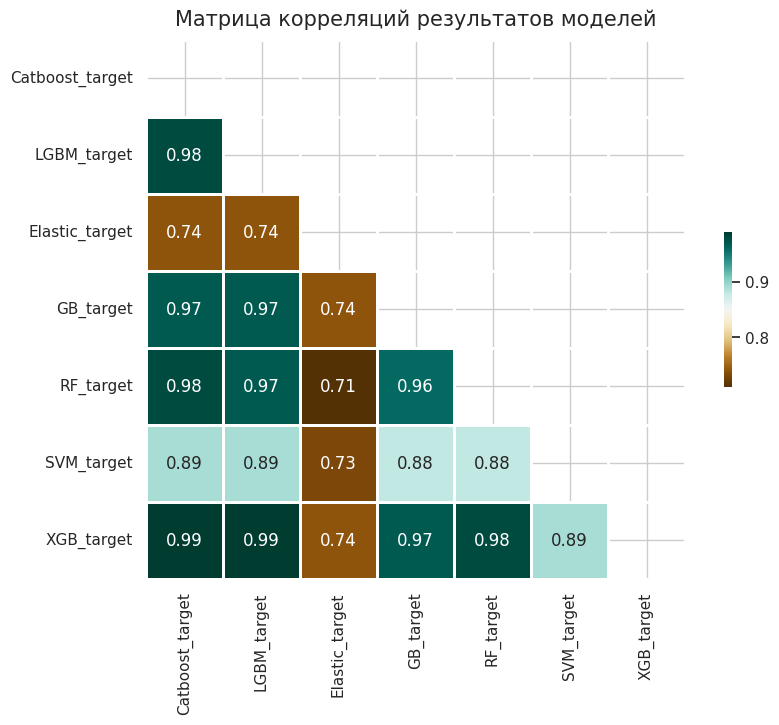

In [ ]:
sns.set_style("whitegrid")

mask = np.triu(np.ones_like(df_sub.corr(numeric_only=True), dtype=bool))

heatmap = sns.heatmap(df_sub.corr(numeric_only=True).round(2),
                      annot=True,
                      square=True,
                      cmap="BrBG",
                      cbar_kws={"fraction": 0.01},
                      linewidth=1,
                      mask=mask)

heatmap.set_title("Матрица корреляций результатов моделей", fontdict={"fontsize": 15}, pad=10);

Бустинговые модели имеют высокую корреляцию между собой. Вероятно, потому что они и предсказывают целевую переменую наиболее точно. Но следует сблендить результаты этих моделей с принципиально другими.

Обучим модели на одной и той же валидационной выборке.

In [ ]:
# разбиение на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
df_val = pd.DataFrame()
df_val['target_val'] = y_val.values
scores = {}

for el in bst_mdls:
   y_pred = bst_mdls[el].predict(X_val)
   df_val[el] = y_pred
   scores[el] = mean_squared_error(y_true=y_val, y_pred=y_pred, squared=False)

<Axes: >

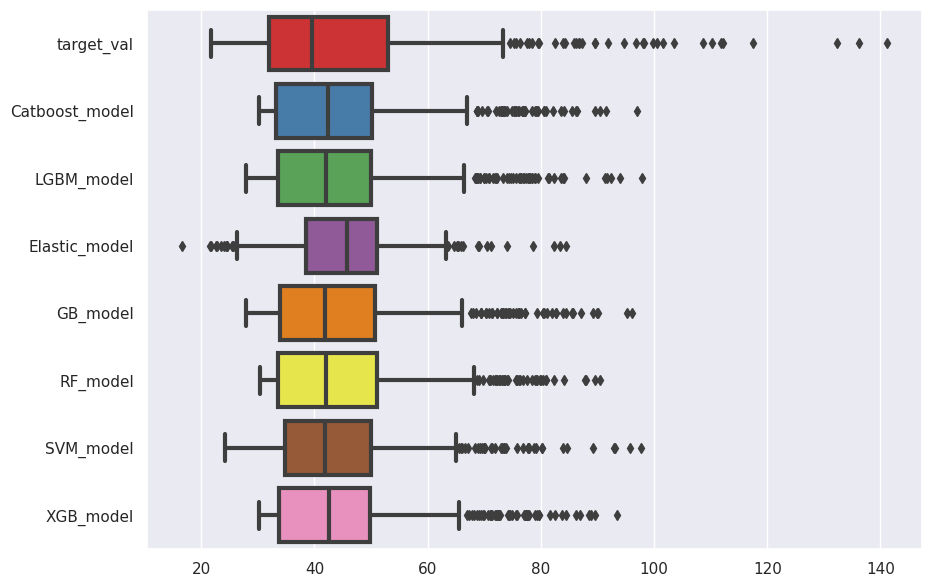

In [ ]:
sns.set(rc={"figure.figsize":(10, 7)})
sns.boxplot(data=df_val,whis=1,linewidth=3,orient="h",palette="Set1")

In [ ]:
# sns.displot(df_val, kind="hist", aspect=2)

По распределению можно предположить, что некоторые простые модели, например, Elastic, KNN (не попал в финальный вариант работы) очень хорошо предсказывает валидационную выборку. Но вероятно имеет место переобучение, т.к. во время обучения в optuna была утечка данных. Поэтому лучше ориентироваться на показатели RMSE по кросс-валидации на optuna.

Видно, что модели Catboost и LGBM достаточно плохо предсказывают малые значения таргета. Вероятно этих значений не так много и модели не очень хорошо на них обучаются. Попытаемся скомпенсировать это добавив к нашим бустингам линейную модель. Для блендинга нам требуется взять 2 бустинга и одну модель не бустинг. Возьмём в наш набор для блендинга Catboost, LGBM и SVM.

# Блендинг

Попробуем подобрать веса для блендинга, исходя из поведения на валидационной выборке.

In [ ]:
df_val.head()

,target_val,Catboost_model,LGBM_model,Elastic_model,GB_model,RF_model,SVM_model,XGB_model
0,35.531250,46.683696,46.472419,45.115550,48.727055,45.892647,42.867884,47.188889
1,29.343750,31.417925,31.615200,44.618992,33.130172,31.833901,34.103194,32.815533
2,41.375000,30.923593,32.283804,35.759284,34.168572,34.089744,31.644408,33.053764
3,26.703125,33.872101,32.752787,30.389919,33.356304,33.890035,33.689247,33.057117
4,33.281250,46.463045,45.090191,44.505353,44.665389,47.837180,44.605014,46.534046


In [ ]:
df_val_blending = df_val[['Catboost_model',
                          'LGBM_model',
                          'SVM_model',
                          'target_val']]
df_val_blending.head()

,Catboost_model,LGBM_model,SVM_model,target_val
0,46.683696,46.472419,42.867884,35.531250
1,31.417925,31.615200,34.103194,29.343750
2,30.923593,32.283804,31.644408,41.375000
3,33.872101,32.752787,33.689247,26.703125
4,46.463045,45.090191,44.605014,33.281250


In [ ]:
scores_mdls_chosen = {}
for i in range(len(df_val_blending.columns)):
    _ = re.sub(r'_model', '_score', df_val_blending.columns[i])
    if _ in mean_scores:
        scores_mdls_chosen.update({_: mean_scores[_]})

scores_mdls_chosen

{'Catboost_score': 11.528727793270349,
 'LGBM_score': 11.612262446913308,
 'SVM_score': 12.771331905554307}

Бустинги дают нам лучшие значения метрики. И, кроме того, эти значения метрики достаточно близки.

In [ ]:
# высчитаем веса для результатов модели пропорционально метрике RMSE
scores = 1 / np.array(list(scores_mdls_chosen.values()))
all_sum = np.sum(scores)
weights_ = scores / all_sum
# weights_

weights = {}
for f, b in zip(scores_mdls_chosen, weights_):
    weights.update({f: b})
print(weights)

{'Catboost_score': 0.3453623046141505, 'LGBM_score': 0.34287788604118363, 'SVM_score': 0.31175980934466574}


Можем высчитать коэффициенты для блендинга автоматически, пропрорционально усреднённым по фолдам метрикам. Но мне это давало результат хуже, чем выставление вручную.

Веса, которые были высчитаны, исходя из средних rmse, достаточно близки. Рассмотрим есть ли другой вариант для решения.

Предположим, что хотим зафиксировать одинаковый вклад в прогноз от бустингов. И тогда найдём оптимальные веса для модели SVM.

In [ ]:
lst = [x / 100.0 for x in range(1, 30, 1)]

scores = []
for w in lst:
    n = 1 - w
    y_pred = df_val_blending['Catboost_model'] * (n/2) +  df_val_blending['LGBM_model'] * (n/2) + df_val_blending['SVM_model'] * w
    scores.append(mean_squared_error(y_true=df_val_blending['target_val'].values, y_pred=y_pred, squared=False))

min = lst[np.argmin(scores)]
print(min)

0.13


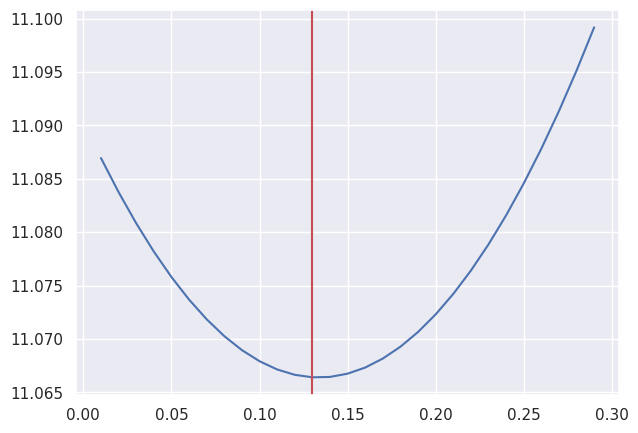

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(lst, scores)
plt.axvline(min, c='r')
plt.show()

Важно отметить, что всё таки полноценно зафиксировать перебор параметров optuna не удалось. (В документации optuna сказано, что параллельность вычислений не позволяет этого сделать. И необходимо выполнять вычисления последовательно).  Поэтому при разных запусках ноутбука возможны разные варианты минимума. (В моих запусках наблюдал от 0.01 до 0.23). В любом случае, бустинги перетягивают на себя качество модели. И использовать веса, пропорциональные средним метрикам - нецелесообразно.

In [ ]:
df_sub_blending = df_sub[['car_id',
                          'Catboost_target',
                          'LGBM_target',
                          'SVM_target']]

In [ ]:
# вариант выставления весов вручную
# df_sub_blending['target_reg'] = df_sub_blending['Catboost_target'] * 0.445 + \
#      df_sub_blending['LGBM_target'] * 0.445 + df_sub_blending['SVM_target'] * 0.11
# df_sub_blending.head()

# выставление весов пропроционально средней метрике
# df_sub_blending['target_reg'] = df_sub_blending['Catboost_target'] * weights['Catboost_score'] + \
#      df_sub_blending['LGBM_target'] * weights['LGBM_score'] + df_sub_blending['SVM_target'] * weights['SVM_score']
# df_sub_blending.head()

# выставление весов исходя из оптимального минимума, при одинаковом вкладе бустингов
df_sub_blending['target_reg'] = df_sub_blending['Catboost_target'] * ((1 - min) / 2)+ \
     df_sub_blending['LGBM_target'] * ((1 - min) / 2) + df_sub_blending['SVM_target'] * min
df_sub_blending.head()

,car_id,Catboost_target,LGBM_target,SVM_target,target_reg
0,P17494612l,44.269476,48.860750,37.363210,45.368866
1,N-1530212S,32.148753,36.022324,38.331765,34.637548
2,B-1154399t,32.534999,30.741058,32.297850,31.723805
3,F12725233R,34.120984,37.529150,44.226032,36.917192
4,l-1139189J,32.356600,31.277469,42.158862,33.161472


In [ ]:
# получаем предсказания от блендинга
df_sub_blending = df_sub_blending[['car_id', 'target_reg']]
df_sub_blending.to_csv('result_0.csv', index=False)

**На тесте: RMSE вашего решения 11.9. Нужно не более 11.85**

# Стекинг

К сожалению, в моём варианте исполнения pystack не хотел напрямую работать с моделями, которые были сформированы. Необходимо было немного по-другому обрабатывать входные данные (+ для работы с библиотекой необходимо было корректировать строки, связанные с joblib). Воспользуемся стандартным sklearn стекингом.

Для стекинга возьмём 2 бустинга XGB и Gradient.

In [ ]:
# список базовых моделей
estimators = [
    ("RF", bst_mdls['RF_model']),
    ("Gradient", bst_mdls['GB_model']),
    ("XGBoost", bst_mdls['XGB_model']),]

meta_model = StackingRegressor(estimators=estimators,
                               final_estimator=ElasticNet(max_iter=704,
                               l1_ratio=0.23,
                               alpha=0.004),
                               n_jobs=-1,
                               verbose=False)

stacking_regressor = meta_model
stacking_regressor.fit(X, y)

StackingRegressor(estimators=[('RF',
                               TransformedTargetRegressor(regressor=Pipeline(steps=[('feature_preprocessor',
                                                                                     ColumnTransformer(transformers=[('num',
                                                                                                                      Pipeline(steps=[('imputer',
                                                                                                                                       SimpleImputer(strategy='median')),
                                                                                                                                      ('scaler',
                                                                                                                                       StandardScaler())]),
                                                                                                                      ['car_rating',
                                                                                                                       'year_to_start',
                                                                                                                       'riders',
                                                                                                                       'year_to_work',
                                                                                                                       'mean_rating',
                                                                                                                       'distance_sum',
                                                                                                                       'rating_min',
                                                                                                                       'speed_max'...
                                                                                                  lambda=9,
                                                                                                  learning_rate=None,
                                                                                                  max_bin=340,
                                                                                                  max_cat_threshold=None,
                                                                                                  max_cat_to_onehot=None,
                                                                                                  max_delta_step=None,
                                                                                                  max_depth=4,
                                                                                                  max_leaves=10,
                                                                                                  min_child_weight=11.75,
                                                                                                  missing=nan,
                                                                                                  monotone_constraints=None,
                                                                                                  n_estimators=100,
                                                                                                  n_jobs=-1, ...))]),
                                                          transformer=StandardScaler()))],
                  final_estimator=ElasticNet(alpha=0.004, l1_ratio=0.23,
                                             max_iter=704),
                  n_jobs=-1, verbose=False)

In [ ]:
preds = stacking_regressor.predict(X_sub)
df_sub_stacking = df_sub[['car_id',]]
df_sub_stacking['target_reg'] = preds
df_sub_stacking.to_csv('result_1.csv', index=False)

In [ ]:
end = time.time()
all_time = (end - start) / 60
all_time

20.925259387493135

**На тесте: Вы побили порог в 11.85 RMSE: ваше решение дает RMSE=11.8.**

# Ансамбль

Воспользуемся библиотекой Kaggle-Ensemble-Guide и усредним значения блендинга  и стекинга.

In [ ]:
!git clone https://github.com/MLWave/Kaggle-Ensemble-Guide

fatal: destination path 'Kaggle-Ensemble-Guide' already exists and is not an empty directory.


In [ ]:
!python /content/Kaggle-Ensemble-Guide/src/kaggle_avg.py "/content/result_*.csv" "/content/all_blended.csv"

parsing: /content/result_1.csv
parsing: /content/result_0.csv
wrote to /content/all_blended.csv


**На тесте: Вы побили порог в 11.85 RMSE: ваше решение дает RMSE=11.8.**

# Сохранение моделей

In [ ]:
for i, mdl in enumerate(bst_mdls):
    with open(f'model_{i}.pkl', "wb") as f:
        pickle.dump(bst_mdls[mdl], f)

# Результаты

* Обучили несколько моделей. Многие модели не попали в окончательное решение. (MLPregressor, самописный MLPRegressor, GaussianProcessRegressor, TabNetRegressor, ...). Не попали из-за оптимизации количества моделей или из-за времени обучения.
* Для всех моделей были написаны пайплайны для обработки признаков и использования их в моделях.
* Для всех моделей числовые признаки стандартизировались. Это практически не влияло на работу бустинговых алгоритмов, но на более простых типа GaussianProcessRegressor, KNN, elastic, SVM, ... получали значительное улучшение.
* Для всех моделей использовался подбор гиперпараметров библиотекой optuna. Для уменьшения времени работы ноутбука диапазон параметров были ограничены уже исходя из предыдущих запусков.
* Полностью зафиксировать подбор гиперпараметров через optuna не удалось. Возможно отключение распределённых вычислений решит проблему. Но в данном исследовании мы использовали все возможности для ускорения вычислений. Для воспроизведения результатов лучше сохранять полученные модели и параметры.
* Модели обучались используя кросс-валидацию. Также для некоторых моделей использовался pruning. Где возможно использовались sheduler и early-stoppings.
* Ни одна из моделей не давала требуемый результат в отдельности. Лучше всего по метрике себя показывали бустинговые алгоритмы. Из более простых алгоритмов в моих запусках лучше всего на данной задаче проявил метод опорных векторов SVM.
Среди нейронных сетей лучше всего показывала себя модель TabNet. Её результаты были сопоставимы с бустинговыми алгоритмами, пусть и всё таки хуже (RMSE = 12). Исключил эту модель из-за времени обучения. MLP regressor почему-то выдавал около 16 по RMSE. Самописная модель MLP выдавала около 13-14, но вероятно самописную можно было ещё улучшать.
* Блендинг не решил проблему (впрочем, как уже было сказано из-за некой неопределённости результатов пару раз получал необходимый результат и на простом блендинге с весами). Стекинг моделей в данном случае позволил получить необходимое значение метрики.